# Overview

In this notebook the `AUCMEDI`-Framework is used to train a deep neural network to classify images of chest X-rays as either `normal` or `viral pneumonia`. Together with Explainable Artifical Intelligence (XAI) this might aid medical professionals to diagnose viral pneumonia based on X-ray images.  

The dataset contains 1341 normal and 1345 viral pneumonia images (= 2686 images in total).  
It is split into a train-dataset (70%, 1881 images)  and two test-datasets (15% each, 403 and 402 images).  
The *train-dataset* is futher split in 3 parts for k-fold-crossvalidation.  
The *first test-dataset* is used to evaluate individual models (dataset: `test_models`) and the *second test-dataset* (dataset: `test_ensemble`) is used to evaluate a Random-Forest ensemble of the models of the three cross-validation-folds.  

**Pipeline:**  
* Data prepation and split into different sets
* Neural Network set up
* Training with k-fold-crossvalidation
  * Training-history inspection
  * Saving of parameters for valuation (ROC-Curve, f1-Score)
  * Computation of Classification-Report and Confusion-Matrix
* Evaluation of the performace of the 3 folds
  * Average f1-score
  * ROC-Curves
* Combination of the predictions of the 3 folds with Ensemble learning
  * Random-Forest-Ensemble
  * Soft Majority Vote Ensemble
* Evaluation of the Ensembles
  * f1-Scores
  * ROC-Curves
* Explainable Artifical Intelligence (XAI)
  * Gradcam
  * Lime

# Loading packages

Deep-learning frameworks and libraries often have a lot of dependencies. 
`AUCMEDI` has the following requirements:  

```
tensorflow==2.3.0  
keras-applications==1.0.8  
numpy==1.18.5  
pillow==7.2.0  
albumentations==0.5.2  
pandas==1.1.4  
scikit-learn
```

Therefore I check which of these requirements are already satisfied and which are not. Every command that should be run at the system shell needs to be prefixed with `!` in `iPython`.

In [ ]:
!pip list -v | grep [Tt]ensorflow
!pip list -v | grep [Kk]eras-applications
!pip list -v | grep [Nn]umpy
!pip list -v | grep [Pp]illow
!pip list -v | grep [Aa]lbumentations
!pip list -v | grep [Pp]andas
!pip list -v | grep [Sc]ikit-learn

tensorflow                    2.5.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-datasets           4.0.1               /usr/local/lib/python3.7/dist-packages pip
tensorflow-estimator          2.5.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-gcs-config         2.5.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-hub                0.12.0              /usr/local/lib/python3.7/dist-packages pip
tensorflow-metadata           1.1.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-probability        0.13.0              /usr/local/lib/python3.7/dist-packages pip
numpy                         1.19.5              /usr/local/lib/python3.7/dist-packages pip
Pillow                        7.1.2               /usr/local/lib/python3.7/dist-packages pip
albumentations                0.1.12              /usr/local/lib/python3.7/dist-packages pip
pandas                        1.1.5               /usr/local/lib/pytho

Depending on the output I install the dependencies for `AUCMEDI`.  
After that I have to restart the runtime.

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.3.0
!pip install keras-applications==1.0.8
!pip uninstall numpy
!pip install numpy==1.18.5
!pip uninstall pillow
!pip install pillow==7.2.0
!pip uninstall albumentations
!pip install albumentations==0.5.2
!pip uninstall pandas
!pip install pandas==1.1.4
!pip install scikit-learn


Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 320.4 MB 45 kB/s 
     |████████████████████████████████| 2.9 MB 63.1 MB/s 
     |████████████████████████████████| 459 kB 56.1 MB/s 
     |████████████████████████████████| 20.1 MB 95.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Foun

     |████████████████████████████████| 50 kB 4.8 MB/s 
Found existing installation: numpy 1.18.5
Uninstalling numpy-1.18.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.18.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-ed201abd.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-34a18dc3.3.7.so
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.18.5
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatibl

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PIL/*
    /usr/local/lib/python3.7/dist-packages/Pillow-7.1.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libfreetype-69f25d5e.so.6.17.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libjpeg-ba7bf5af.so.9.4.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblcms2-a6801db4.so.2.0.8
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblzma-99449165.so.5.2.5
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libopenjp2-b3d7668a.so.2.3.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libpng16-bedcb7ea.so.16.37.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libtiff-41910f6d.so.5.5.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebp-122bd20b.so.7.1.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebpdemux-2db559e5.so.2.0.6
    /usr/local/lib/python3.7/dist-packages/Pillow.li

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 72 kB 770 kB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
     |████████████████████████████████| 948 kB 56.5 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.1.5
     |████████████████████████████████| 9.5 MB 8.1 MB/s 


Installing `folium==0.2.1` because `datascience 0.10.6` requires `folium==0.2.1` (see the output above).

In [ ]:
!pip install folium==0.2.1

     |████████████████████████████████| 69 kB 4.6 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=3e428ff5cd3f706baae9b4f0cad976f18176beac693e0163b9aa1df79cc8f2af
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


After installing all required packages, I restart the runtime to make use of the new installations.

Since I restarted the runtime, I check again, which packages are installed.

In [ ]:
!pip list -v | grep [Tt]ensorflow
!pip list -v | grep [Kk]eras-applications
!pip list -v | grep [Nn]umpy
!pip list -v | grep [Pp]illow
!pip list -v | grep [Aa]lbumentations
!pip list -v | grep [Pp]andas
!pip list -v | grep [Sc]ikit-learn
!pip list -v | grep [Ii]mgaug
!pip list -v | grep [Ff]olium

tensorflow                    2.3.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-datasets           4.0.1               /usr/local/lib/python3.7/dist-packages pip
tensorflow-estimator          2.3.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-gcs-config         2.5.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-hub                0.12.0              /usr/local/lib/python3.7/dist-packages pip
tensorflow-metadata           1.1.0               /usr/local/lib/python3.7/dist-packages pip
tensorflow-probability        0.13.0              /usr/local/lib/python3.7/dist-packages pip
numpy                         1.18.5              /usr/local/lib/python3.7/dist-packages pip
Pillow                        7.2.0               /usr/local/lib/python3.7/dist-packages pip
albumentations                0.5.2               /usr/local/lib/python3.7/dist-packages pip
pandas                        1.1.4               /usr/local/lib/pytho

The output look fine, all requirements are fulfilled. Therefore I can proceed installing `AUCMEDI`.

In [ ]:
!pip install aucmedi

     |████████████████████████████████| 168 kB 9.5 MB/s 


# Loading and preparing the data

On Google-Colab it is useful to mount google-drive. So it is possible to save data there beyond the runtime. However local variables will be lost, after a runtime ends or connection is lost for more then a few seconds/minutes. 

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


I save the image data in zip-format in my Google-drive and unzip it into the Colab-workspace.

In [ ]:
!unzip "/content/drive/MyDrive/Pneumonia_Classification.zip" -d "/content/Pneumonia_Classification"

Archive:  /content/drive/MyDrive/Pneumonia_Classification.zip
   creating: /content/Pneumonia_Classification/NORMAL/
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (10).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (100).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1000).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1001).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1002).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1003).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1004).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1005).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1006).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1007).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1008).png  
  inflating: /content/Pneumonia_Classification/NORMAL/NORMAL (1009).png 

## Checking initial data-distribution

First I'm going to check the inital data-distribution between `normal` and `viral pneumonia` images.

In [ ]:
import os

normal = os.listdir("/content/Pneumonia_Classification/NORMAL")
pneumonia = os.listdir("/content/Pneumonia_Classification/Viral Pneumonia")

print(str(len(normal)) + " normal images and " + str(len(pneumonia)) + " pneumonia images")

1341 normal images and 1345 pneumonia images


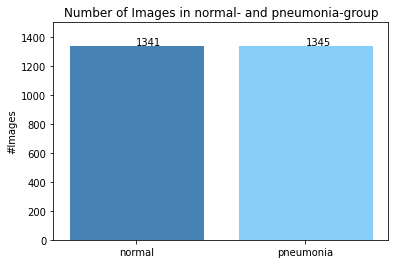

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

height = [len(normal), len(pneumonia)]
bars = ('normal', 'pneumonia')
x_pos = np.arange(len(bars))
plt.bar(x_pos, height, color=['steelblue', 'lightskyblue'], edgecolor='white')
plt.xticks(x_pos, bars)
plt.ylim([0, 1500])
plt.ylabel('#Images')
plt.annotate(len(normal), (x_pos[0], height[0]))
plt.annotate(len(pneumonia), (x_pos[1], height[1]))
plt.title('Number of Images in normal- and pneumonia-group')
plt.savefig('/content/drive/MyDrive/DataDistribution/' + 'before_splitting' + '.png')   
plt.show()

As we can see the data are (almost) equally distributed between the classes `normal` and `viral pneumonia`. This is an advantage, because no class weighting needs to be done during training.

## Splitting the data

Now I'm going to put the images in separate folders for `train` and `test` datasets.
The test-dataset is further split into a test-dataset for the testing of models (`test_models`) and a test-dataset for testing of the ensemble (which will be calculated later on, `test_ensemble`).  

In [ ]:
from pathlib import Path

Path("/content/Pneumonia_Classification_train/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/Pneumonia_Classification_train/Viral Pneumonia").mkdir(parents=True, exist_ok=True)
Path("/content/Pneumonia_Classification_test_models/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/Pneumonia_Classification_test_models/Viral Pneumonia").mkdir(parents=True, exist_ok=True)
Path("/content/Pneumonia_Classification_test_ensemble/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/Pneumonia_Classification_test_ensemble/Viral Pneumonia").mkdir(parents=True, exist_ok=True)

In [ ]:
from aucmedi.data_processing import io_data
ds_loader = io_data.input_interface("directory", path_imagedir="/content/Pneumonia_Classification", path_data=None, training=True, ohe=False)

`ds_loader[0]` contains the file_path after `"/content/Pneumonia_Classification"`

In [ ]:
ds_loader[0]

['NORMAL/NORMAL (1).png',
 'NORMAL/NORMAL (10).png',
 'NORMAL/NORMAL (100).png',
 'NORMAL/NORMAL (1000).png',
 'NORMAL/NORMAL (1001).png',
 'NORMAL/NORMAL (1002).png',
 'NORMAL/NORMAL (1003).png',
 'NORMAL/NORMAL (1004).png',
 'NORMAL/NORMAL (1005).png',
 'NORMAL/NORMAL (1006).png',
 'NORMAL/NORMAL (1007).png',
 'NORMAL/NORMAL (1008).png',
 'NORMAL/NORMAL (1009).png',
 'NORMAL/NORMAL (101).png',
 'NORMAL/NORMAL (1010).png',
 'NORMAL/NORMAL (1011).png',
 'NORMAL/NORMAL (1012).png',
 'NORMAL/NORMAL (1013).png',
 'NORMAL/NORMAL (1014).png',
 'NORMAL/NORMAL (1015).png',
 'NORMAL/NORMAL (1016).png',
 'NORMAL/NORMAL (1017).png',
 'NORMAL/NORMAL (1018).png',
 'NORMAL/NORMAL (1019).png',
 'NORMAL/NORMAL (102).png',
 'NORMAL/NORMAL (1020).png',
 'NORMAL/NORMAL (1021).png',
 'NORMAL/NORMAL (1022).png',
 'NORMAL/NORMAL (1023).png',
 'NORMAL/NORMAL (1024).png',
 'NORMAL/NORMAL (1025).png',
 'NORMAL/NORMAL (1026).png',
 'NORMAL/NORMAL (1027).png',
 'NORMAL/NORMAL (1028).png',
 'NORMAL/NORMAL (1029)

`ds_loader[1]` contains the labels

In [ ]:
ds_loader[1]

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [ ]:
from aucmedi.sampling.split import sampling_split
train, test_models, test_ensemble = sampling_split(ds_loader[0], ds_loader[1], sampling=[0.7, 0.15, 0.15], stratified=True, iterative=False, seed=123)

I could directy use `train`, `test_models` and `test_ensemble` and work with these.  
Hence, I wouldn't need to put the images in different folders.  
However, I'm going to do so anyways. If I had these folders on my own disk I could restart from here without repeating the previous steps. Alternatively I could save the images on google-drive, but they need to much space.

In [ ]:
train_set = train[0]
test_set_models = test_models[0]
test_set_ensemble = test_ensemble[0]

In [ ]:
# Train Directory:
train_dir = '/content/Pneumonia_Classification_train'
# Test Directory Models:
test_dir_models = '/content/Pneumonia_Classification_test_models'
# Test Directory Ensemble:
test_dir_ensemble = '/content/Pneumonia_Classification_test_ensemble'

In [ ]:
import shutil
import os

for image in train_set:
  filename = image
  src = os.path.join('/content/Pneumonia_Classification', filename)
  dst = os.path.join(train_dir, filename)
  shutil.copyfile(src, dst)

for image in test_set_models:
  filename = image
  src = os.path.join('/content/Pneumonia_Classification', filename)
  dst = os.path.join(test_dir_models, filename)
  shutil.copyfile(src, dst)

for image in test_set_ensemble:
  filename = image
  src = os.path.join('/content/Pneumonia_Classification', filename)
  dst = os.path.join(test_dir_ensemble, filename)
  shutil.copyfile(src, dst)

## Checking the data-distribution after splitting

In [ ]:
normal_train = os.listdir("/content/Pneumonia_Classification_train/NORMAL")
normal_test_models = os.listdir("/content/Pneumonia_Classification_test_models/NORMAL")
normal_test_ensemble = os.listdir("/content/Pneumonia_Classification_test_ensemble/NORMAL")

pneumonia_train = os.listdir("/content/Pneumonia_Classification_train/Viral Pneumonia")
pneumonia_test_models = os.listdir("/content/Pneumonia_Classification_test_models/Viral Pneumonia")
pneumonia_test_ensemble = os.listdir("/content/Pneumonia_Classification_test_ensemble/Viral Pneumonia")

print(str(len(normal_train)) + " normal train images, " + str(len(normal_test_models)) + " normal model test images, " + str(len(normal_test_ensemble)) + " normal ensemble test images")
print(str(len(pneumonia_train)) + " pneumonia test images, " + str(len(pneumonia_test_models)) + " pneumonia model test images, " + str(len(pneumonia_test_ensemble)) + " pneumonia ensemble test images")

939 normal train images, 201 normal model test images, 201 normal ensemble test images
942 pneumonia test images, 202 pneumonia model test images, 201 pneumonia ensemble test images


Then I plot the distribution of the images after splitting the dataset.

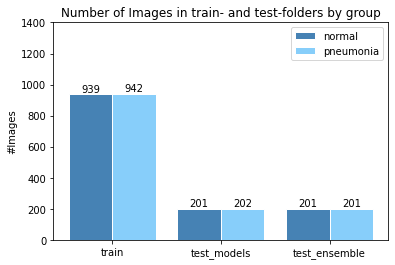

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Path("/content/drive/MyDrive/DataDistribution").mkdir(parents=True, exist_ok=True)

groups = [[len(normal_train), len(normal_test_models), len(normal_test_ensemble)], [len(pneumonia_train), len(pneumonia_test_models), len(pneumonia_test_ensemble)]]
labels = ['train','test_models', 'test_ensemble']

colors = ['steelblue', 'lightskyblue']
width = 0.8 / len(groups)
 
pos = np.array(range(len(groups[0]))) 
 
for i in range(len(groups)):
    plt.bar(pos+i*width, groups[i], width=width, color=colors[i], edgecolor='white')
    
    for k in range(len(groups[0])):
        plt.annotate(groups[i][k], (pos[k]+i*width, groups[i][k]), ha='center', va='bottom')
    
plt.xticks(pos+i*width/2, labels=labels)
plt.legend(['normal', 'pneumonia'], loc='upper right')
plt.title('Number of Images in train- and test-folders by group')
plt.ylim([0, 1400])
plt.ylabel('#Images')

plt.savefig('/content/drive/MyDrive/DataDistribution/' + 'train_test' + '.png')    
plt.show()


## Showing 6 sample images of every folder

I loop through my folders to show 6 sample images of every folder.  

/content/Pneumonia_Classification_train
/content/Pneumonia_Classification_train/Viral Pneumonia
/content/Pneumonia_Classification_train/NORMAL
/content/Pneumonia_Classification_test_models
/content/Pneumonia_Classification_test_models/Viral Pneumonia
/content/Pneumonia_Classification_test_models/NORMAL
/content/Pneumonia_Classification_test_ensemble
/content/Pneumonia_Classification_test_ensemble/Viral Pneumonia
/content/Pneumonia_Classification_test_ensemble/NORMAL


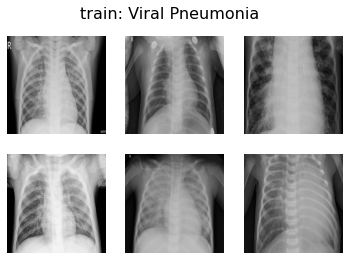

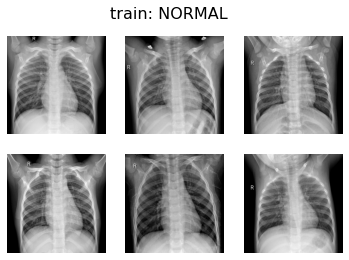

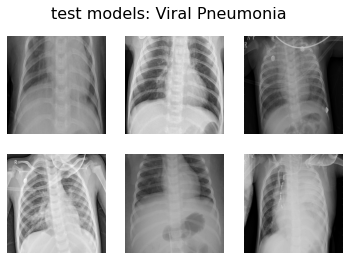

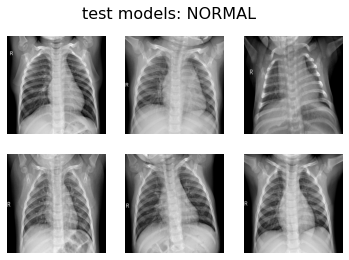

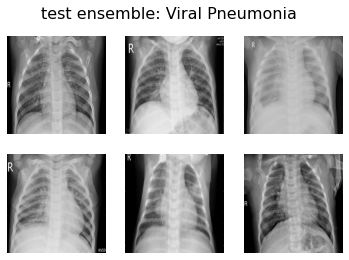

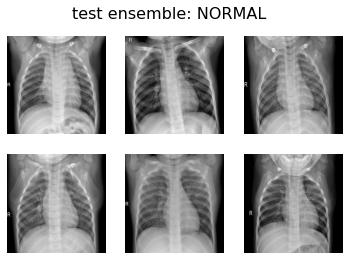

In [ ]:
import matplotlib.pyplot as plt

Path("/content/drive/MyDrive/SampleImages").mkdir(parents=True, exist_ok=True)

train_test = [train_dir, test_dir_models, test_dir_ensemble]
for directory in train_test:
  print(directory)
  if directory == train_dir:
    category = "train"
  if directory == test_dir_models:
    category = "test models"
  if directory == test_dir_ensemble:
    category = "test ensemble"
  for each in os.listdir(directory):
    plt.figure()
    plt.suptitle(category + ": " + each, fontsize=16)
    currentFolder = directory + "/" + each
    print(currentFolder)
    for i, file in enumerate(os.listdir(currentFolder)[0:6]):
      fullpath = currentFolder + "/" + file
      img = plt.imread(fullpath)
      plt.subplot(2, 3, i+1)
      plt.axis('off')
      plt.imshow(img)
      plt.gray()
      plt.savefig('/content/drive/MyDrive/SampleImages/' + category + "_" + each + '.png')
plt.show()

## Splitting for k-fold-cross-validation

So far, I have 3 datasets: `train`, `test_models` and `test_ensemble`.  
But I don't have a dataset for validation (during training) yet.  
This could be created the same way, but would reduce the number of images in each set.  
Therefore I use k-fold-crossvalidation, with k=3.  
Here, the training-set is split into 3 parts and training is performed 3 times. Each time one of the three parts, each time a different one, is used for validation and the other two parts are used for training.  

Other "k" than 3 could be used, but 3 seems reasonable for the size of this dataset and the computational resources available.  

An extreme form of k-fold-crossvalidation is leave-one-out-validation. There, training is performed n times, with n being the size of the dataset. Each time only one datapoint (for example image) serves as validation-set. But this is not performed here, because it is very computationally expensive.

In [ ]:
from aucmedi.data_processing import io_data
ds_loader_train = io_data.input_interface("directory", path_imagedir="/content/Pneumonia_Classification_train", path_data=None, training=True, ohe=False)


In [ ]:
from aucmedi.sampling import kfold
k = 3
sampling = kfold.sampling_kfold(samples = ds_loader_train[0], labels = ds_loader_train[1], n_splits = k, seed = 123)

print("Size of train-set:")
print(len(ds_loader_train[0]))

print("first fold, x_train:")
print(len(sampling[0][0])) 
print("first fold, y_train:")
print(len(sampling[0][1])) 
print("first fold, x_test:")
print(len(sampling[0][2])) 
print("first fold, y_test:")
print(len(sampling[0][3])) 

print("second fold, x_train:")
print(len(sampling[1][0])) 
print("second fold, y_train:")
print(len(sampling[1][1])) 
print("second fold, x_test:")
print(len(sampling[1][2])) 
print("second fold, y_test:")
print(len(sampling[1][3])) 

print("third fold, x_train:")
print(len(sampling[2][0])) 
print("third fold, y_train:")
print(len(sampling[2][1])) 
print("third fold, x_test:")
print(len(sampling[2][2])) 
print("third fold, y_test:")
print(len(sampling[2][3])) 

Size of train-set:
1881
first fold, x_train:
1254
first fold, y_train:
1254
first fold, x_test:
627
first fold, y_test:
627
second fold, x_train:
1254
second fold, y_train:
1254
second fold, x_test:
627
second fold, y_test:
627
third fold, x_train:
1254
third fold, y_train:
1254
third fold, x_test:
627
third fold, y_test:
627


The output shows, that the splitting worked as intended.

## Ploting the number of images in each cross-validation fold

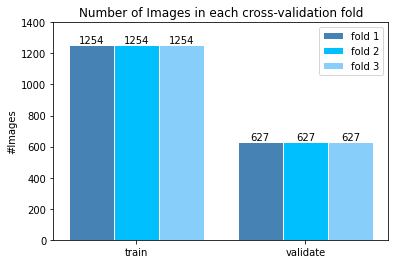

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Path("/content/drive/MyDrive/DataDistribution").mkdir(parents=True, exist_ok=True)

groups = [[len(sampling[0][0]), len(sampling[0][2])], [len(sampling[1][0]), len(sampling[1][2])], [len(sampling[2][0]), len(sampling[2][2])]]
labels = ['train','validate']
 
colors = ['steelblue', 'deepskyblue', 'lightskyblue']
width = 0.8 / len(groups)
 
pos = np.array(range(len(groups[0]))) 
 
for i in range(len(groups)):
    plt.bar(pos+i*width, groups[i], width=width, color=colors[i], edgecolor='white')
    
    for j in range(len(groups[0])):
        plt.annotate(groups[i][j], (pos[j]+i*width, groups[i][j]), ha='center', va='bottom')
    
plt.xticks (pos+i*width/2, labels=labels)
plt.legend(['fold 1', 'fold 2', 'fold 3'], loc='upper right')
plt.title('Number of Images in each cross-validation fold')
plt.ylim([0, 1400])
plt.ylabel('#Images')

plt.savefig('/content/drive/MyDrive/DataDistribution/' + 'cross_validation' + '.png')        
plt.show()

# Neural Network

Here, the Neural Network is setup.

**Setting up image augmentation.**  
Image-augmentation increases the image-set is artificially by adding small transformations to the original images such as rotations or changes of the contrast or saturation. It can be applied offline or online. With offline image-augmentation those transformations are applied to the images and the images are saved back on disk before they are loaded again for training. With online image-augmentation the transformations are applied to each image when loaded with the data generator. `AUCMEDI` supports both methods. However, this is not applied here, because it doesn't bring additional advantages in this particular case and is computationally expensive - I just show for demonstration purposes how image augmentation would be setup. It might be useful for more difficult classification-problems, or in cases when only few images are available for training.

In [ ]:
from aucmedi.data_processing import augmentation
data_aug = augmentation.Image_Augmentation(flip=True, rotate=True, brightness=True, contrast=True, saturation=True, hue=True, scale=True, 
                                           crop=False, grid_distortion=False, compression=False, gaussian_noise=False, gaussian_blur=False, 
                                           downscaling=False, gamma=False, elastic_transform=False)

**Setting the models architecture.**  
MobileNetV2 is used for training. Advantages of MobileNetV2 are:  
* A version that is pretrained with ImageNet exists, which is useful for transferlearing  
* The network is relatively small, so that it can be applied on mobile devices or other hardware without much resources.  

For a more detailed explaination of MobileNetV2 see https://machinethink.net/blog/mobilenet-v2/ and https://keras.io/api/applications/mobilenet/.

3 channels are used even though images are gray-scale because transfer-learning will be used and 3 channels are necessary for transfer-learning.

In [ ]:
from aucmedi.neural_network import architectures
architecture = architectures.Architecture_MobileNetV2(channels = 3)

**Setting the NeuralNetwork:**  
* `n_labels = 2`, because there are two categories, `NORMAL` and `viral pneumonia`  
* `channels = 3`, because the model is setup with 3 channels (in this case for transfer learning)
* `architecture` = the architeture from above (`MobileNetV2`) 
* `pretrained_weights = True`, means that pretrained weights from Imagenet will be used  
* `loss="categorical_crossentropy"`, because in multiclass, single-label-classification categorical_crossentropy is usually used as loss  
  * if the problem was a binary classification (only one class), the loss-function would be `binary_crossentropy`
  * for regression to arbitary values it would be `mse` and for regression to values between 0 and 1 it would be `mse` or `binary_crossentropy`
* `metrics=["categorical_accuracy"]` -> other metrics could be included here
* `activation_output="softmax"` -> this is the last layer activation function  
  * Softmax takes a vector of inputs and normalizes it to a probability distribution
  * It ensures for every image each class is assigned a probability between 0 and 1 and the probabilities over classes for every image add up to 1 
* `fcl_dropout=True`, means that a Dense & Dropout layer in the last classification layer will be used -> this helps to reduce overfitting
* other arguments (and some of these) are standard values

**Notes on Transferlearning:**
* The goal of transferlearning is to use pretrained models on another classification task.
* Since the pretrained models were pretrained on a different but very large image-set (mostly Imagenet) their trained weights won't fit perfectly for the task at hand (the closer the better).
* The weights of the pretained models are most likely still better than an untrained model.
* Therefore the pretrained model can be used.
* The weights of the pretrained model of all layers but the classification head are then frozen during training of the new task.
* This is done, because if the weights wouldn't be frozen they would be "deleted" by the first epoch of training.
* The classification-head, however, can't be frozen, because it needs to be adapted to the new task.
* After some epochs of training the freezing is undone, so that the weights can be adapted to the new task.
* With transfer-leaning models can be trained even when fewer data/images are available. 
* Furthermore time is saved, because the weights are preinitialized. 

In [ ]:
from aucmedi.neural_network import model
  
model = model.Neural_Network(n_labels=2, channels=3, input_shape=(224, 224, 3), architecture = architecture, pretrained_weights=True, 
                             loss="categorical_crossentropy", metrics=["categorical_accuracy"], activation_output="softmax", 
                             fcl_dropout=True, learninig_rate=0.0001, batch_queue_size=10, workers=1, multiprocessing=False, verbose=1)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
from pathlib import Path
Path("/content/drive/MyDrive/Models").mkdir(parents=True, exist_ok=True)

**Importing and configuring Callbacks.**  
EarlyStopping Callback can be setup here, but modelCheckpoint Callback needs to be setup later, because the path depends on the cross-validation fold.

The EarlyStopping callback stops the training if (in this setup) the validation-loss is not improved for 5 epochs.  
This can help to reduce the risk of overfitting and furthermore reduces unnecessary training-time.

In [ ]:
import tensorflow as tf

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# K-fold cross-validation




## Fold 1

Configuring the ModelCheckpoint Callback for the first fold. Only the best model will be saved.

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Models/fold1.h5', monitor='val_loss', save_best_only=True)

**Setting up the DataGenerators and training the model for the first fold**  

**train_generator**:
* `samples=sampling[0][0]` -> these are the x_train-data of the first fold (see above)
* `path_imagedir` = path were the data are stored
* `image_format = None`, because it is already included in the samples-information in this case
* `resize=(224,224)`, because the model needs input images of size (224,224,3)
* `data_aug=None`, because Image-augmetation doesn't add any additional value in this case. *data_aug* (see above) could be added here. If images are not saved on disked and reloaded later (`prepare_images = False`) this is online image-augmentation.
* `grayscale=False`, because images of the size (224, 224, 3) are needed for transfer-learning.
* `seed=123` is a seed for reproducability
* all other arguments (and some of these) contain standard-values

**val_generator:**  
The only difference to the `train_generator` is, that now the `x_test-data` (`sampling[0][2]`) are assigned to samples and the `y_test-data` (`sampling[0][3]`) to lables. 
If there was used an image augmentation for the `train_generator`, this wouldn't be used for the `val_generator`.  

**training:**  
* The model is trained.
* `history_start` and `history_end` are saved in local variables for later plotting.  
* any number of predefined callbacks can be included in the callbacks-list
* `class_weights=None`, because the classes are equally distributed in this case. If they weren't weights could be added here to reweight the different classes. This is often useful for medical image-classification.
* `transfer_learning=True` as transferlearning (from Imagenet) is used

In [ ]:
from aucmedi.data_processing import data_generator

train_generator = data_generator.DataGenerator(samples=sampling[0][0], path_imagedir="/content/Pneumonia_Classification_train", 
                                                labels=sampling[0][1], image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                                shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                sample_weights=None, seed=123, workers=1)
val_generator = data_generator.DataGenerator(samples=sampling[0][2], path_imagedir="/content/Pneumonia_Classification_train",
                                              labels=sampling[0][3], image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                              shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                              sample_weights=None, seed=123, workers=1)

history_start, history_end = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=[earlyStopping, modelCheckpoint], class_weights=None, transfer_learning=True)

Epoch 1/5
40/40 [==============================] - 40s 995ms/step - loss: 0.8889 - categorical_accuracy: 0.7193 - val_loss: 0.5340 - val_categorical_accuracy: 0.7321
Epoch 2/5
40/40 [==============================] - 38s 959ms/step - loss: 0.4135 - categorical_accuracy: 0.8118 - val_loss: 0.2026 - val_categorical_accuracy: 0.9219
Epoch 3/5
40/40 [==============================] - 38s 952ms/step - loss: 0.3022 - categorical_accuracy: 0.8756 - val_loss: 0.1727 - val_categorical_accuracy: 0.9282
Epoch 4/5
40/40 [==============================] - 37s 936ms/step - loss: 0.2001 - categorical_accuracy: 0.9282 - val_loss: 0.2015 - val_categorical_accuracy: 0.9314
Epoch 5/5
40/40 [==============================] - 37s 930ms/step - loss: 0.1938 - categorical_accuracy: 0.9274 - val_loss: 0.1762 - val_categorical_accuracy: 0.9282
Epoch 6/20
40/40 [==============================] - 40s 998ms/step - loss: 1.0964 - categorical_accuracy: 0.4745 - val_loss: 0.1892 - val_categorical_accuracy: 0.9234
Epo

### Plotting the Training-history

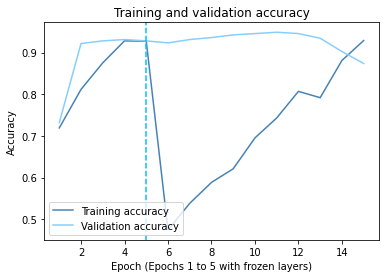

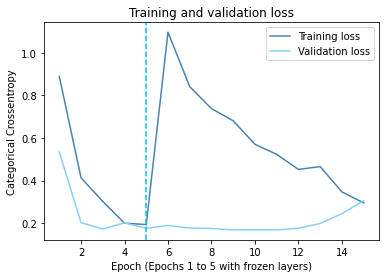

In [ ]:
Path("/content/drive/MyDrive/TrainingHistory").mkdir(parents=True, exist_ok=True)

acc_freezed = history_start.history['categorical_accuracy']
acc_unfreezed = history_end.history['categorical_accuracy']

val_acc_freezed = history_start.history['val_categorical_accuracy']
val_acc_unfreezed = history_end.history['val_categorical_accuracy']

loss_freezed = history_start.history['loss']
loss_unfreezed = history_end.history['loss']

val_loss_freezed = history_start.history['val_loss']
val_loss_unfreezed = history_end.history['val_loss']

epochs = range(1, len(acc_freezed + acc_unfreezed) + 1)

plt.plot(epochs, acc_freezed + acc_unfreezed, 'steelblue', label='Training accuracy')
plt.plot(epochs, val_acc_freezed + val_acc_unfreezed, 'lightskyblue', label='Validation accuracy')
plt.axvline(x=5, color='deepskyblue', linestyle="--")
plt.title('Training and validation accuracy')
plt.xlabel('Epoch (Epochs 1 to 5 with frozen layers)')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.savefig('/content/drive/MyDrive/TrainingHistory/' + 'fold1' + '_' + 'accuracy' '.png') 
plt.figure()


plt.plot(epochs, loss_freezed + loss_unfreezed, 'steelblue', label='Training loss')
plt.plot(epochs, val_loss_freezed + val_loss_unfreezed, 'lightskyblue', label='Validation loss')
plt.axvline(x=5, color='deepskyblue', linestyle="--")
plt.title('Training and validation loss')
plt.xlabel('Epoch (Epochs 1 to 5 with frozen layers)')
plt.ylabel('Categorical Crossentropy')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/TrainingHistory/' + 'fold1' + '_' + 'loss' '.png') 
plt.show()

* The first 5 epochs are trained with frozen layers.  
* We can see that the transferlearning helps with fast learning.  The same phenomenon occurs for the other 2 folds.  
* After the layers are unfrozen, there is a sharp drop in training accuracy and increase in training loss, because due to the unfreezing of the layers the correct weights have to be found again.  
* For the validation loss and accuracy this abrupt chance after epoch 5 is not observed. 
* This can be explained by the way these metrics are calculated by tensorflow:
Training-metrics are calculated on the average *of* the last epoch while validation-metrics are calculated on the average *after* the last epoch. Furthermore BatchNormalization and Dropout layers are deactivated during validation (https://www.tensorflow.org/tutorials/images/transfer_learning).
* Due to the callback EarlyStopping training is stopped after 5 epochs with no improvement in validation-loss, but we can still see that training and validation curves trend against each other. (-> Risk of Overfitting if training wasn't stopped/best model wouldn't be saved.)



### Evaluation

**The DataGenerator for prediction is setup.**  
`training = True`, only in order to be able to use "directory" as input_interface.  
Since `labels=None`, labels are not known, when predicting.  

In [ ]:
from aucmedi.data_processing import io_data
from aucmedi.data_processing import data_generator

ds_loader_predict = io_data.input_interface("directory", path_imagedir="/content/Pneumonia_Classification_test_models", path_data=None, training=True, ohe=False)
predict_generator = data_generator.DataGenerator(samples=ds_loader_predict[0], path_imagedir="/content/Pneumonia_Classification_test_models", 
                                                 labels=None, image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)

Predicting with the best model of fold1 on data `test_models`

In [ ]:
model.load(file_path='/content/drive/MyDrive/Models/fold1.h5')
prediction = model.predict(prediction_generator=predict_generator)

13/13 [==============================] - 6s 488ms/step


#### Saving output-data for creation of the ROC-curve

The ROC-Curve itself is explained later, when printing the ROC-Curve.

* *false-positive-rate (fpr)*, *true-positive-rate (tpr)*, *thresholds* and *area-under-the-curve (auc)* are calculated with *roc_curve* and *auc* functions from sklearn and saved in lists.
* for the calculation the data first need to be transformed:
  * `y` = the labels  the position of the max value on the label-array on axis 1  
  Example: `[[1,0],[1,0],[0,1],[0,1]] -> [0,0,1,1]` -> first two images are labled as `normal`, secound two images are labled as `viral pneumonia`.
  * `scores` = the prediction that was made for each image for the category `viral pneumonia` -> this prediction should be close to 0, if the image is a `normal` image and close to 1 if it is a `viral pneumonia`-image  
  Example:  `[[0.98,0.02],[0.89,0.11],[0.02,0.98],[0.2,0.8]]` ->  
  `np.swapaxes([[0.98,0.02],[0.89,0.11],[0.02,0.98],[0.2,0.8]], 0, 1)` ->  
  `[[0.98,0.89,0.02,0.2],[0.02,0.11,0.98,0.8]]` -> the data of the second-subarray (`scores[1]`) contain the prediction on the class `viral pneumonia` for each image. If these predictions were perfect, they were the same as `y` = the labels.

In [ ]:
from sklearn import metrics

fprs = []
tprs = []
thresholds = []
aucs = []

scores = np.swapaxes(prediction, 0, 1)
scores = scores[1]
y = np.argmax(ds_loader_predict[1], axis=1)
fpr, tpr, threshold = metrics.roc_curve(y, scores, pos_label=1)
auc = metrics.auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
aucs.append(auc)

#### Classification-Report and Confusion-Matrix
**The classification report and confusion matrix are plotted using functions of sklearn.**  
For this purpose data need to be transformed similar as above.   
* `truth = y` (see above)
* `prediction = np.argmax(prediction, axis=1)`  
Example: If the predictions were `[[0.98,0.12],[0.89,0.1],[0.11,0.99],[0.2,0.97]]` the argmax of these predictions on axis=1 is `[0,0,1,1]`.  

**Precision** = Ability of a classifier not to label a negative example as positive = True Positives/(True Positives + False Positives) = True Positives/(All Examples that *were put* in the class)

**Recall** = Ability of a classifier to find all positive examples = True Positives/(True Positives + False Negatives) = True Positives/(All Examples that *belong* in the class)

**f1-score** = weighted average of precision and recall = 2 * (precision * recall) / (precision + recall)
* macro-f1-score: class imbalances are not taken into account
* weighted-f1-score: weighted by support (support being the number of images used for calculation)
* micro-f1-score: in this case the same as accuracy, therefore not shown  

For an explanation of different f1-scores see also: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score and https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report.

**accuracy** = fraction of correct predictions


              precision    recall  f1-score   support

      normal       0.93      0.96      0.95       201
   pneumonia       0.96      0.93      0.94       202

    accuracy                           0.95       403
   macro avg       0.95      0.95      0.95       403
weighted avg       0.95      0.95      0.95       403

true negatives: 193, false positives: 8, false negatives: 14, true positives: 188
Sensitivity: 0.9306930693069307, False-Negative-Rate: 0.06930693069306931, Specificity: 0.9601990049751243, False-Positive-Rate: 0.03980099502487562


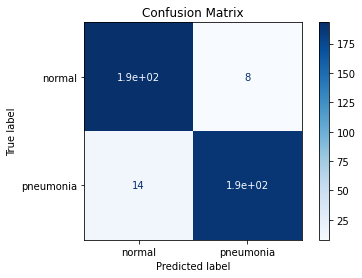

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, f1_score

Path("/content/drive/MyDrive/ConfusionMatrix").mkdir(parents=True, exist_ok=True)

prediction = np.argmax(prediction, axis=1)
truth = y

print(classification_report(truth, prediction, target_names=['normal','pneumonia']))

cm = confusion_matrix(truth, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "pneumonia"])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/ConfusionMatrix/' + 'fold1' + '_' + 'ConfusionMatrix' + '.png') 

tn, fp, fn, tp = cm.ravel()
print("true negatives: " + str(tn) + ", false positives: " + str(fp) + ", false negatives: " + str(fn) + ", true positives: " + str(tp))
print("Sensitivity: " + str(tp/(tp+fn)) + ", False-Negative-Rate: " + str(fn/(tp+fn)) + ", Specificity: " + str(tn/(tn+fp)) + ", False-Positive-Rate: " + str(fp/(tn+fp)) )

**Interpretation of the Confusion-Matrix:**  
Images that are put in the upper-left and lower-right fields are correctly classified (true negatives and true positives respectively).  
Images that are put in the lower-left and upper-right fields are classified incorrectly (false negatives and false positives respectively).   
In most medical contexts the false negatives (lower left) are most concerning.

**Saving f1-scores for later analysis:**  
The macro-f1-score is saved, because the f1-score shouldn't be weighted by the size of the classes. In this case it wouldn't make much (if any) difference (see above), because the classes are of equal size. But often in medical classification the interesting class (f.e. a rare condition) contains far less images or examples than the control class. Then it would be deceptive to weight the f1-score by the class-size, because much likely the classification works better for the control class, just because there are more examples. Therefore macro-f1-score should be used instead of weighted-f1-score in these cases (or other measures taken).

In [ ]:
f1_scores = []
f1_scores.append(f1_score(truth, prediction, average= 'macro'))

**Resetting weights:**

In [ ]:
model.reset_weights()

## Fold 2
The same procedures as for fold 1 are run.

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Models/fold2.h5', monitor='val_loss', save_best_only=True)

In [ ]:
train_generator = data_generator.DataGenerator(samples=sampling[1][0], path_imagedir="/content/Pneumonia_Classification_train", 
                                                labels=sampling[1][1], image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                                shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                sample_weights=None, seed=123, workers=1)
val_generator = data_generator.DataGenerator(samples=sampling[1][2], path_imagedir="/content/Pneumonia_Classification_train",
                                              labels=sampling[1][3], image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                              shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                              sample_weights=None, seed=123, workers=1)

history_start, history_end = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=[earlyStopping, modelCheckpoint], class_weights=None, transfer_learning=True)

Epoch 1/5
40/40 [==============================] - 41s 1s/step - loss: 0.5921 - categorical_accuracy: 0.7177 - val_loss: 0.4793 - val_categorical_accuracy: 0.7719
Epoch 2/5
40/40 [==============================] - 39s 970ms/step - loss: 0.3956 - categorical_accuracy: 0.8278 - val_loss: 0.2690 - val_categorical_accuracy: 0.8884
Epoch 3/5
40/40 [==============================] - 39s 977ms/step - loss: 0.2417 - categorical_accuracy: 0.9035 - val_loss: 0.2300 - val_categorical_accuracy: 0.8995
Epoch 4/5
40/40 [==============================] - 39s 974ms/step - loss: 0.2178 - categorical_accuracy: 0.9155 - val_loss: 0.1762 - val_categorical_accuracy: 0.9330
Epoch 5/5
40/40 [==============================] - 38s 955ms/step - loss: 0.1919 - categorical_accuracy: 0.9242 - val_loss: 0.1777 - val_categorical_accuracy: 0.9362
Epoch 6/20
40/40 [==============================] - 41s 1s/step - loss: 1.1093 - categorical_accuracy: 0.4888 - val_loss: 0.1919 - val_categorical_accuracy: 0.9314
Epoch 7/2

### Plotting the Training-history

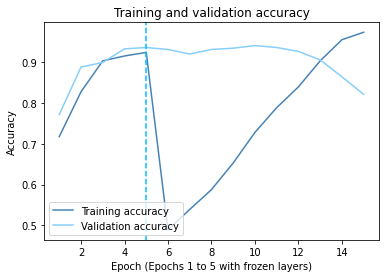

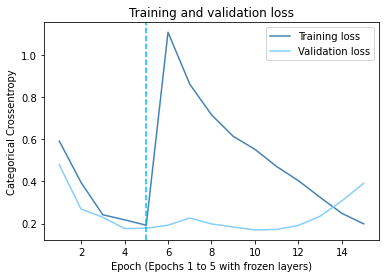

In [ ]:
Path("/content/drive/MyDrive/TrainingHistory").mkdir(parents=True, exist_ok=True)

acc_freezed = history_start.history['categorical_accuracy']
acc_unfreezed = history_end.history['categorical_accuracy']

val_acc_freezed = history_start.history['val_categorical_accuracy']
val_acc_unfreezed = history_end.history['val_categorical_accuracy']

loss_freezed = history_start.history['loss']
loss_unfreezed = history_end.history['loss']

val_loss_freezed = history_start.history['val_loss']
val_loss_unfreezed = history_end.history['val_loss']

epochs = range(1, len(acc_freezed + acc_unfreezed) + 1)

plt.plot(epochs, acc_freezed + acc_unfreezed, 'steelblue', label='Training accuracy')
plt.plot(epochs, val_acc_freezed + val_acc_unfreezed, 'lightskyblue', label='Validation accuracy')
plt.axvline(x=5, color='deepskyblue', linestyle="--")
plt.title('Training and validation accuracy')
plt.xlabel('Epoch (Epochs 1 to 5 with frozen layers)')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.savefig('/content/drive/MyDrive/TrainingHistory/' + 'fold2' + '_' + 'accuracy' '.png') 
plt.figure()


plt.plot(epochs, loss_freezed + loss_unfreezed, 'steelblue', label='Training loss')
plt.plot(epochs, val_loss_freezed + val_loss_unfreezed, 'lightskyblue', label='Validation loss')
plt.axvline(x=5, color='deepskyblue', linestyle="--")
plt.title('Training and validation loss')
plt.xlabel('Epoch (Epochs 1 to 5 with frozen layers)')
plt.ylabel('Categorical Crossentropy')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/TrainingHistory/' + 'fold2' + '_' + 'loss' '.png') 
plt.show()

### Evaluation

In [ ]:
model.load(file_path='/content/drive/MyDrive/Models/fold2.h5')
prediction = model.predict(prediction_generator=predict_generator)

13/13 [==============================] - 8s 598ms/step


#### Saving output-data for creation of the ROC-curve

In [ ]:
scores = np.swapaxes(prediction, 0, 1)
scores = scores[1]

fpr, tpr, threshold = metrics.roc_curve(y, scores, pos_label=1)
auc = metrics.auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
aucs.append(auc)

#### Classification-Report and Confusion-Matrix

              precision    recall  f1-score   support

      normal       0.93      0.97      0.95       201
   pneumonia       0.97      0.93      0.95       202

    accuracy                           0.95       403
   macro avg       0.95      0.95      0.95       403
weighted avg       0.95      0.95      0.95       403

true negatives: 195, false positives: 6, false negatives: 14, true positives: 188
Sensitivity: 0.9306930693069307, False-Negative-Rate: 0.06930693069306931, Specificity: 0.9701492537313433, False-Positive-Rate: 0.029850746268656716


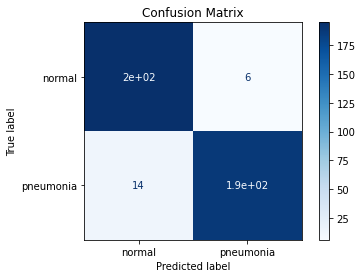

In [ ]:
Path("/content/drive/MyDrive/ConfusionMatrix").mkdir(parents=True, exist_ok=True)

prediction = np.argmax(prediction, axis=1)

print(classification_report(truth, prediction, target_names=['normal','pneumonia']))

cm = confusion_matrix(truth, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "pneumonia"])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/ConfusionMatrix/' + 'fold2' + '_' + 'ConfusionMatrix' + '.png') 

tn, fp, fn, tp = cm.ravel()
print("true negatives: " + str(tn) + ", false positives: " + str(fp) + ", false negatives: " + str(fn) + ", true positives: " + str(tp))
print("Sensitivity: " + str(tp/(tp+fn)) + ", False-Negative-Rate: " + str(fn/(tp+fn)) + ", Specificity: " + str(tn/(tn+fp)) + ", False-Positive-Rate: " + str(fp/(tn+fp)) )

In [ ]:
f1_scores.append(f1_score(truth, prediction, average= 'macro'))

In [ ]:
model.reset_weights()

## Fold 3
The same procedures as for fold 1 and 2 are run.

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Models/fold3.h5', monitor='val_loss', save_best_only=True)

In [ ]:
train_generator = data_generator.DataGenerator(samples=sampling[2][0], path_imagedir="/content/Pneumonia_Classification_train", 
                                                labels=sampling[2][1], image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                                shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                sample_weights=None, seed=123, workers=1)
val_generator = data_generator.DataGenerator(samples=sampling[2][2], path_imagedir="/content/Pneumonia_Classification_train",
                                              labels=sampling[2][3], image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                              shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                              sample_weights=None, seed=123, workers=1)

history_start, history_end = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=[earlyStopping, modelCheckpoint], class_weights=None, transfer_learning=True)

Epoch 1/5
40/40 [==============================] - 40s 999ms/step - loss: 0.6247 - categorical_accuracy: 0.6970 - val_loss: 0.3704 - val_categorical_accuracy: 0.8293
Epoch 2/5
40/40 [==============================] - 38s 962ms/step - loss: 0.4212 - categorical_accuracy: 0.8270 - val_loss: 0.1899 - val_categorical_accuracy: 0.9298
Epoch 3/5
40/40 [==============================] - 38s 947ms/step - loss: 0.2687 - categorical_accuracy: 0.8852 - val_loss: 0.2258 - val_categorical_accuracy: 0.9107
Epoch 4/5
40/40 [==============================] - 39s 965ms/step - loss: 0.3082 - categorical_accuracy: 0.8971 - val_loss: 0.1674 - val_categorical_accuracy: 0.9394
Epoch 5/5
40/40 [==============================] - 39s 967ms/step - loss: 0.1793 - categorical_accuracy: 0.9274 - val_loss: 0.1437 - val_categorical_accuracy: 0.9442
Epoch 6/20
40/40 [==============================] - 41s 1s/step - loss: 1.2645 - categorical_accuracy: 0.4888 - val_loss: 0.1555 - val_categorical_accuracy: 0.9362
Epoch 

### Plotting the Training-history

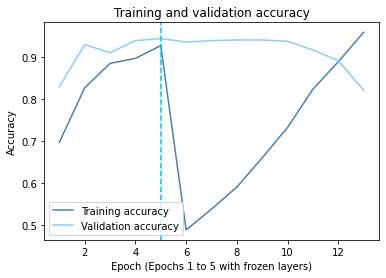

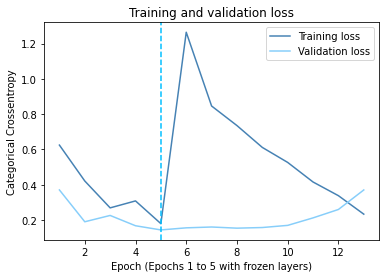

In [ ]:
Path("/content/drive/MyDrive/TrainingHistory").mkdir(parents=True, exist_ok=True)

acc_freezed = history_start.history['categorical_accuracy']
acc_unfreezed = history_end.history['categorical_accuracy']

val_acc_freezed = history_start.history['val_categorical_accuracy']
val_acc_unfreezed = history_end.history['val_categorical_accuracy']

loss_freezed = history_start.history['loss']
loss_unfreezed = history_end.history['loss']

val_loss_freezed = history_start.history['val_loss']
val_loss_unfreezed = history_end.history['val_loss']

epochs = range(1, len(acc_freezed + acc_unfreezed) + 1)

plt.plot(epochs, acc_freezed + acc_unfreezed, 'steelblue', label='Training accuracy')
plt.plot(epochs, val_acc_freezed + val_acc_unfreezed, 'lightskyblue', label='Validation accuracy')
plt.axvline(x=5, color='deepskyblue', linestyle="--")
plt.title('Training and validation accuracy')
plt.xlabel('Epoch (Epochs 1 to 5 with frozen layers)')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.savefig('/content/drive/MyDrive/TrainingHistory/' + 'fold3' + '_' + 'accuracy' '.png') 
plt.figure()


plt.plot(epochs, loss_freezed + loss_unfreezed, 'steelblue', label='Training loss')
plt.plot(epochs, val_loss_freezed + val_loss_unfreezed, 'lightskyblue', label='Validation loss')
plt.axvline(x=5, color='deepskyblue', linestyle="--")
plt.title('Training and validation loss')
plt.xlabel('Epoch (Epochs 1 to 5 with frozen layers)')
plt.ylabel('Categorical Crossentropy')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/TrainingHistory/' + 'fold3' + '_' + 'loss' '.png') 
plt.show()

### Evaluation

In [ ]:
model.load(file_path='/content/drive/MyDrive/Models/fold3.h5')
prediction = model.predict(prediction_generator=predict_generator)

13/13 [==============================] - 8s 602ms/step


#### Saving output-data for creation of the ROC-curve

In [ ]:
scores = np.swapaxes(prediction, 0, 1)
scores = scores[1]

fpr, tpr, threshold = metrics.roc_curve(y, scores, pos_label=1)
auc = metrics.auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
aucs.append(auc)

#### Classification-Report and Confusion-Matrix

              precision    recall  f1-score   support

      normal       0.94      0.95      0.94       201
   pneumonia       0.95      0.94      0.94       202

    accuracy                           0.94       403
   macro avg       0.94      0.94      0.94       403
weighted avg       0.94      0.94      0.94       403

true negatives: 190, false positives: 11, false negatives: 12, true positives: 190
Sensitivity: 0.9405940594059405, False-Negative-Rate: 0.0594059405940594, Specificity: 0.945273631840796, False-Positive-Rate: 0.05472636815920398


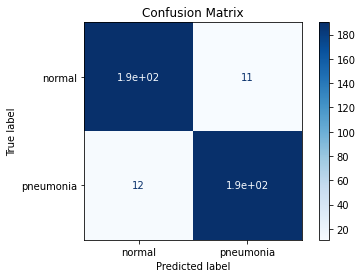

In [ ]:
Path("/content/drive/MyDrive/ConfusionMatrix").mkdir(parents=True, exist_ok=True)

prediction = np.argmax(prediction, axis=1)

print(classification_report(truth, prediction, target_names=['normal','pneumonia']))

cm = confusion_matrix(truth, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "pneumonia"])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/ConfusionMatrix/' + 'fold3' + '_' + 'ConfusionMatrix' + '.png') 

tn, fp, fn, tp = cm.ravel()
print("true negatives: " + str(tn) + ", false positives: " + str(fp) + ", false negatives: " + str(fn) + ", true positives: " + str(tp))
print("Sensitivity: " + str(tp/(tp+fn)) + ", False-Negative-Rate: " + str(fn/(tp+fn)) + ", Specificity: " + str(tn/(tn+fp)) + ", False-Positive-Rate: " + str(fp/(tn+fp)) )

In [ ]:
f1_scores.append(f1_score(truth, prediction, average= 'macro'))

In [ ]:
model.reset_weights()

# Final Evaluation

## Average f1-score

Calculating the average f1-score:

In [ ]:
f1_scores = np.asarray(f1_scores)
f1_scores.mean()

0.9462287650929232

## ROC-Curve

The ROC-Curve (Receiver-Operating-Curve) plots the False-Positive-Rate (FPR) against the True-Positive-Rate (TPR) for different Thresholds of classification.  

**Example:**  

If predictions for `viral pneumonia` for 10 images were `[0.1, 0.9, 1.0, 0.5, 0.4, 0.6, 0.8, 0.2, 0.7]` there *could* be 10 different thresholds for classifying these 10 images as viral pneumonia, namely `0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0`.  

Depending on which of these images actually *are* `viral pneumonia` images the different threshold would lead to different False-Positive and False-Negative-Rates.  

For example, if images with predictions `[0.1,0.2,0.3,0.4,0.5]` are `normal` and images with predictions `[0.6,0.7,0.8,0.9,1.0]` are `viral_pneumonia`, then the False-Positive-Rate for `Threshold>=0.2` would be  

```
FPR = (False Positives)/(False Positives + True Negatives)=4/(4+1)=0.8
TPR = (True Positives)/(True Positives + False Negatives)=5/5=1
```

But for `Threshold>=0.8` it would be  

```
FPR = (False Positives)/(False Positives + True Negatives)=0
TPR = (True Positives)/(True Positives + False Negatives)=3/(3+2)=0.6
```

In the ROC-Curve the False-Positive-Rate and the True-Positive-Rate are plotted against each other for different thresholds.  

For point (1,1) all "positives" were correctly identified, but also none of the "control" samples was correctly identified. Or, in other words, the True and the False Positive Rate is 1.

The diagonal line shows where `True Positive Rate = False Positive Rate`. This would be realized by chance, if the predictor worked at random.  

The Area under the Curve (AUC) serves as quality-measurement. In the worst case (random-performance) it is 0.5 and in the best case 1.0.

### Calculating the average ROC-Curve

While it is easy to plot one or several ROC-curves in one figure it requires more preparation to plot the average of several ROC-curves.  

I based the calculation of the average ROC-curve of the three folds on:  
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem  

The diffuculty is, that for each fold different False- and True-Positive-Rates exists. For this reason, a mean can't be calculated because the arrays (or vectors) have different lengths. Even if the length would be the same by change a simple mean calculation would be wrong, because it wouldn't take into account the different distrubution of False- and True-Positive-Rates.  

Therefore the solution is to first aggregate all False-Positive-Rates (FPR) into one vector: `all_fpr = np.unique(np.concatenate([fprs[i] for i in range(k)]))`  

This will serve as the x-axis of the average ROC-curve.  

Now the True-Positive-Rate (TPR) needs to be interpolated. The TPR is the corresponding y-points to the x-points that are already collected:  
* Thus for each x-point there is one y-point -> the vectors all_fpr and mean_tpr have equal length -> the vector mean_tpr can be prepared with `mean_tpr = np.zeros_like(all_fpr)`
* The mean_tpr can be interpolated with the `interp`-function of numpy.
* The interpolation needs to be run 3 times (for the 3 folds) and is simply summed together.
* Therefore at the end the mean_tpr is divided by 3: `mean_tpr /= k`


In [ ]:
from numpy import interp
from sklearn.metrics import auc

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprs[i] for i in range(k)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(k):
    mean_tpr += interp(all_fpr, fprs[i], tprs[i])

# Finally average it and compute AUC
mean_tpr /= k

auc_mean = auc(all_fpr, mean_tpr)

### Printing the ROC-Curves

Printing the ROC-Curve for the 3 folds and the average ROC-curve

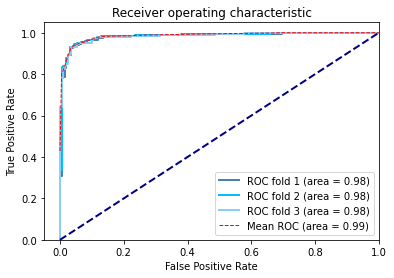

In [ ]:
Path("/content/drive/MyDrive/ROCCurve").mkdir(parents=True, exist_ok=True)

plt.figure()

plt.plot(fprs[0], tprs[0], color='steelblue',
        lw=2, label='ROC fold 1 (area = %0.2f)' % aucs[0])
plt.plot(fprs[1], tprs[1], color='deepskyblue',
        lw=2, label='ROC fold 2 (area = %0.2f)' % aucs[1])
plt.plot(fprs[2], tprs[2], color='lightskyblue',
        lw=2, label='ROC fold 3 (area = %0.2f)' % aucs[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(all_fpr, mean_tpr, color="red",
         lw=1, linestyle='--', label='Mean ROC (area = %0.2f)' % auc_mean)

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/ROCCurve/' + 'ROCCurve' + '.png') 
plt.show()

We can see that all folds perform about equally well.

# Ensemble


With cross-validation three different models (one for each of the three folds) are produced. In this case for each fold the best model was saved (because ModelCheckpoint-Callback with `save_best_only=True` was used).  

The predictions of these 3 models can be combined into an **Ensemble** in order to produce one common - most likely better and more stable - prediction.

## Random-Forest-Ensemble

Random forests are an ensemble method themselves. They work the following:
1.	Bootstrapped Dataset: Random sample from the dataset are drawn. One sample can be drawn several times. Therefore the bootstrapped dataset has the same size as the original dataset but doesn’t contain all data.
2.	Random Decision Trees: A decision tree with a random number of variables - here possible variables are fold1, fold2, fold3 – in each step is build based on the bootstrapped dataset. This is called feature bagging.
3.	Back to Step 1 and repeat. This way many random decision trees are generated.
4.	Tree bagging for the prediction of new data: The most common decision of the decision trees is the final decision.


**Implementation:**  
First, the predictions for `test_models` and `test_ensemble` as well as the truth-data can be writen in a csv-file in order to make them easily accessible later.  

For this reason the predictions of all folds are loaded and written into an array.  
Due to the way the Random-Forest-function of sklearn works, each prediction needs to be altered a bit: Only the predictions for `viral pneumonia` on each image are saved and written into the array (`np.compress([False, True], single_prediction, axis=1)`).  

After all predictions are saved into the array, the array needs to be reshaped (`reshape` and `swapaxes`) in order to produce the correct format to write 401 (`test_models`) or 402 (`test_ensemble`) lines (the predictions for each image on class `viral pneumonia`) in 3 columns (`fold1`, `fold2`, `fold3`).  

The truth-data can be gathered directly with `np.compress([False, True], ds_loader_predict[1], axis=1)` from the returned labels of the data-loader.


In [ ]:
import csv
import os
import numpy as np
from numpy import array
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

Path("/content/drive/MyDrive/Ensemble").mkdir(parents=True, exist_ok=True)

models = os.listdir('/content/drive/MyDrive/Models/')

ds_loader_predict_ensemble = io_data.input_interface("directory", path_imagedir="/content/Pneumonia_Classification_test_ensemble", path_data=None, training=True, ohe=False)
predict_generator_ensemble = data_generator.DataGenerator(samples=ds_loader_predict_ensemble[0], path_imagedir="/content/Pneumonia_Classification_test_ensemble", 
                                                 labels=None, image_format=None, batch_size=32, resize=(224, 224), data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)

# writing predictions for test_models

prediction = []
for i in range(len(models)):
  path = '/content/drive/MyDrive/Models/' + models[i]
  model.load(file_path=path)
  single_prediction = model.predict(prediction_generator = predict_generator)
  single_prediction = np.compress([False, True], single_prediction, axis=1)
  prediction.append(single_prediction)
prediction = array(prediction)

header = ['fold1', 'fold2', 'fold3']
prediction = prediction.reshape(3,403)
prediction = prediction.swapaxes(0,1)
data = prediction

with open('/content/drive/MyDrive/Ensemble/testModels_predictions_compressed.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  writer.writerows(data)

# writing predictions for test_ensemble

prediction = []
for i in range(len(models)):
  path = '/content/drive/MyDrive/Models/' + models[i]
  model.load(file_path=path)
  single_prediction = model.predict(prediction_generator = predict_generator_ensemble)
  single_prediction = np.compress([False, True], single_prediction, axis=1)
  prediction.append(single_prediction)
prediction = array(prediction)

header = ['fold1', 'fold2', 'fold3']
prediction = prediction.reshape(3,402)
prediction = prediction.swapaxes(0,1)
data = prediction

with open('/content/drive/MyDrive/Ensemble/testEnsemble_predictions_compressed.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(header)
  writer.writerows(data)

# writing truth data for test_models

header_truth = ['truth']
truth_data = np.compress([False, True], ds_loader_predict[1], axis=1)

with open('/content/drive/MyDrive/Ensemble/testModels_truth_compressed.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(header_truth)
  writer.writerows(truth_data)

# writing truth data for test_ensemble

header_truth = ['truth']
truth_data = np.compress([False, True], ds_loader_predict_ensemble[1], axis=1)

with open('/content/drive/MyDrive/Ensemble/testEnsemble_truth_compressed.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(header_truth)
  writer.writerows(truth_data)


13/13 [==============================] - 8s 581ms/step


**Ensemble-learning with Random-Forest-Classifier of sklearn:**  
First the data are loaded from csv-files, then they are put into the RandomForestClassifier and finally the output is evaluated with a Classification-Report and Confusion-Matrix.

              precision    recall  f1-score   support

      normal       0.92      0.96      0.94       201
   pneumonia       0.96      0.92      0.94       201

    accuracy                           0.94       402
   macro avg       0.94      0.94      0.94       402
weighted avg       0.94      0.94      0.94       402

true negatives: 193 false positives: 8 false negatives: 16 true positives: 185
Sensitivity: 0.9203980099502488 False-Negative-Rate: 0.07960199004975124 Specificity: 0.9601990049751243 False-Positive-Rate: 0.03980099502487562


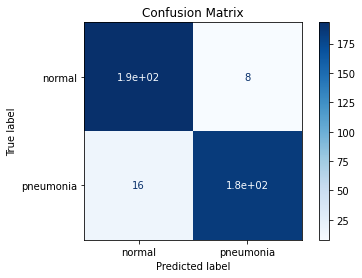

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

X_train = np.asarray(pd.read_csv('/content/drive/MyDrive/Ensemble/testModels_predictions_compressed.csv'))
y_train = np.ravel(pd.read_csv('/content/drive/MyDrive/Ensemble/testModels_truth_compressed.csv'))

X_test = np.asarray(pd.read_csv('/content/drive/MyDrive/Ensemble/testEnsemble_predictions_compressed.csv'))
y_test = np.ravel(pd.read_csv('/content/drive/MyDrive/Ensemble/testEnsemble_truth_compressed.csv'))

rdf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
rdf_clf.fit(X_train, y_train)
X_test_prediction = rdf_clf.predict(X_test)
X_test_proba_prediction = rdf_clf.predict_proba(X_test)

# Printing Classification-Report and Confusion-Matrix to show performance of Ensemble

print(classification_report(y_test, X_test_prediction, target_names=['normal','pneumonia']))

cm = confusion_matrix(y_test, X_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "pneumonia"])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/ConfusionMatrix/' + 'RandomForest_Emsemble' + '_' + 'ConfusionMatrix' + '.png') 

tn, fp, fn, tp = cm.ravel()
print("true negatives: " + str(tn) + " false positives: " + str(fp) + " false negatives: " + str(fn) + " true positives: " + str(tp))
print("Sensitivity: " + str(tp/(tp+fn)) + " False-Negative-Rate: " + str(fn/(tp+fn)) + " Specificity: " + str(tn/(tn+fp)) + " False-Positive-Rate: " + str(fp/(tn+fp)) )

In [ ]:
f1_random_forest_ensemble = f1_score(y_test, X_test_prediction, average= 'macro')

### Saving output-data for creation of the ROC-curve

In [ ]:
scores = np.swapaxes(X_test_proba_prediction, 0, 1)
scores = scores[1]

fpr, tpr, threshold = metrics.roc_curve(y_test, scores, pos_label=1)
auc = metrics.auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
aucs.append(auc)

## Soft Majority Vote Ensemble

Predictions of the models are summed to create a new (ensemble) predictions matrix.  
For every picture the category that has the max. value for this (ensemble) predictions-matrix is taken as the final prediction.  

13/13 [==============================] - 6s 486ms/step
prediction-shape:
(3, 403, 2)
summed-shape:
(403, 2)
final_prediction:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0]
final_prediction.shape:
(403,)
              precision  

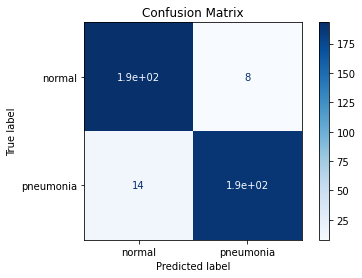

In [ ]:
import os
import numpy as np
from numpy import array
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

Path("/content/drive/MyDrive/ConfusionMatrix").mkdir(parents=True, exist_ok=True)

models = os.listdir('/content/drive/MyDrive/Models/')

prediction = []
for i in range(len(models)):
  path = '/content/drive/MyDrive/Models/' + models[i]
  model.load(file_path=path)
  single_prediction = model.predict(prediction_generator = predict_generator)
  prediction.append(single_prediction)
prediction = array(prediction)

print("prediction-shape:")
print(prediction.shape) # shape is number-of-model * number of pictures * number of categories
summed = np.sum(prediction, axis=0) # summed over the models
print("summed-shape:")
print(summed.shape) # shape is number of pictures * number of categories
final_prediction = np.argmax(summed, axis=1) #category that is the maximum for each picture
print("final_prediction:")
print(final_prediction)
print("final_prediction.shape:")
print(final_prediction.shape)

print(classification_report(truth, final_prediction, target_names=['normal','pneumonia']))

cm = confusion_matrix(truth, final_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "pneumonia"])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/ConfusionMatrix/' + 'MajorityVote_ensemble' + '_' + 'ConfusionMatrix' + '.png') 

tn, fp, fn, tp = cm.ravel()
print("true negatives: " + str(tn) + " false positives: " + str(fp) + " false negatives: " + str(fn) + " true positives: " + str(tp))
print("Sensitivity: " + str(tp/(tp+fn)) + " False-Negative-Rate: " + str(fn/(tp+fn)) + " Specificity: " + str(tn/(tn+fp)) + " False-Positive-Rate: " + str(fp/(tn+fp)) )

In [ ]:
f1_majority_vote_ensemble = f1_score(truth, final_prediction, average= 'macro')

### Saving output-data for creation of the ROC-curve

In [ ]:
scores = np.swapaxes(summed, 0, 1)
scores = scores[1]
scores /= k

fpr, tpr, threshold = metrics.roc_curve(truth, scores, pos_label=1)
auc = metrics.auc(fpr, tpr)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
aucs.append(auc)

# Evaluation of the Ensembles

## f1-scores

Building a list of all f1-scores:

In [ ]:
all_f1_scores = f1_scores.tolist()
all_f1_scores.append(f1_random_forest_ensemble)
all_f1_scores.append(f1_majority_vote_ensemble)
all_f1_scores

[0.9454010247315007,
 0.9503572308450356,
 0.9429280397022333,
 0.9402748545251951,
 0.9454010247315007]

Plotting all f1-scores:

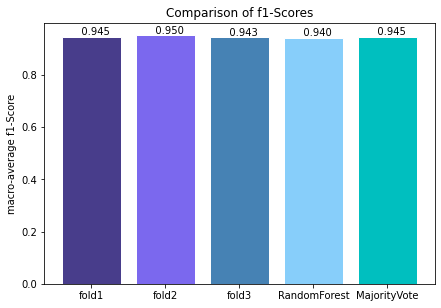

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Path("/content/drive/MyDrive/f1Scores").mkdir(parents=True, exist_ok=True)

f1 = all_f1_scores
labels = ['fold1','fold2','fold3','RandomForest','MajorityVote']

colors = ['darkslateblue', 'mediumslateblue','steelblue', 'lightskyblue', 'c']
 
x_pos = np.arange(len(f1))

plt.figure(figsize=[7, 4.8])
for j in range(len(f1)):
  plt.bar(x_pos[j], f1[j], color=colors[j], edgecolor='white')
  plt.annotate("%8.3f" % (f1[j]), (x_pos[j], f1[j]), ha='center', va='bottom')
    
  plt.xticks(x_pos, labels=labels)

plt.title('Comparison of f1-Scores')
plt.ylabel('macro-average f1-Score')

plt.savefig('/content/drive/MyDrive/f1Scores/' + 'f1_comparison' + '.png')    
plt.show()

## ROC-Curve

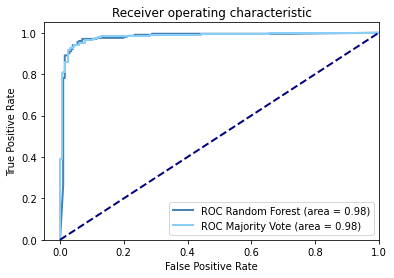

In [ ]:
Path("/content/drive/MyDrive/ROCCurve").mkdir(parents=True, exist_ok=True)

plt.figure()

plt.plot(fprs[3], tprs[3], color='steelblue',
         lw=2, label='ROC Random Forest (area = %0.2f)' % aucs[3])
plt.plot(fprs[4], tprs[4], color='lightskyblue',
         lw=2, label='ROC Majority Vote (area = %0.2f)' % aucs[4])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/ROCCurve/' + 'ROCCurve_ensemble' + '.png') 
plt.show()

In this case the Ensemble performs about equally well as the different folds. However, in more difficult classification problems there should be an advantage of the ensemble.

# XAI

It is the goal of explainability (XAI) to show in human-readable format which features of the input where important for the deep-learning network. This might help for debugging, for example if it is shown that the network learned from background-information that are not important (for example different format of the pictures, or marking symbols etc.)

**Note:**  
Sometimes the connection to the runtime gets lost during the calculation of the XAI due to Out-of-Memory-Error. Since models are saved it is possible to just reload the necessary libraries (like `pandas, numpy, path, os`), depending on where the connection got lost and continue from there.  
Since local variables are lost, the model might need to be defined again:  

```
architecture = architectures.Architecture_MobileNetV2(channels = 3)
model = model.Neural_Network(n_labels=2, channels=3, input_shape=(224, 224, 3), architecture = architecture, pretrained_weights=True, 
                             loss="categorical_crossentropy", metrics=["categorical_accuracy"], activation_output="softmax", 
                             fcl_dropout=True, learninig_rate=0.0001, batch_queue_size=10, workers=1, multiprocessing=False, verbose=1)
```

The imports needed for this part are:

```
from aucmedi.neural_network import model
from aucmedi.neural_network import architectures
```




## Gradcam

With Gradcam the Output-Feature-Maps of the Convolutional-Layers are taken and every channel of this Map is weighted with the gradient of the class that is predicted. Therefore it is shown (in the heatmap) how much the input-image activates the class.

### Averaging Heatmaps of different folds

Since I used k-fold crossvalidation it is useful to apply the XAI-method of choice to all k (here 3) folds. 

Here, I average the heatmaps of the 3 folds for every image by looping through a list of all `normal` images (later the same is done for the `viral pneumonia` images), then calculating the 3 heatmaps, averaging them and adding the averaged heatmap to the image with the `visualize_heatmap` function of `AUCMEDI`.  

The inclusion of `tf.keras.backend.clear_session()` is very important, because otherwise an increasing amout of memory is consumed by keras over time which leads to out of memory error, see: https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session 

In [ ]:
from aucmedi.utils.visualizer import visualize_heatmap
from aucmedi.xai import decoder
from PIL import Image

Path("/content/drive/MyDrive/XAI/gradcam/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/Viral Pneumonia").mkdir(parents=True, exist_ok=True)

normal = os.listdir("/content/Pneumonia_Classification_test_models/NORMAL")
pneumonia = os.listdir("/content/Pneumonia_Classification_test_models/Viral Pneumonia")

for pic in normal:
  tf.keras.backend.clear_session()
  img_path = os.path.join("/content/Pneumonia_Classification_test_models/NORMAL", pic)
  path_xai = os.path.join("/content/drive/MyDrive/XAI/gradcam/NORMAL", pic)
  heatmaps = []
  dg = data_generator.DataGenerator(samples=[pic], path_imagedir="/content/Pneumonia_Classification_test_models/NORMAL", 
                                                 labels=None, image_format=None, batch_size=1, resize=(224, 224), data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)

  for fold in range(k):
    path = '/content/drive/MyDrive/Models/fold' + str(fold+1) + '.h5'
    model.load(file_path=path)
    pred = model.predict(prediction_generator=dg)
    image, htmp = decoder.xai_decoder(dg, model, preds=pred, method="gradcam", layerName=None, alpha=0.4)
    heatmaps.append(htmp)
  heatmaps = array(heatmaps)
  heatmaps = np.squeeze(heatmaps)
  image = np.squeeze(image)
  heatmaps = np.mean(heatmaps,axis=0)
  visualize_heatmap(image, heatmaps, out_path=path_xai, alpha=0.4)
  




1/1 [==============================] - 0s 2ms/step


The warnings are produced by Tensorflow, because the same task is performed repetively. However, there's no easy way to optimize the code in this case.

Same as above but for `viral pneumonia` images:

In [ ]:
import matplotlib.pyplot as plt
import os

for pic in pneumonia:
  tf.keras.backend.clear_session()
  img_path = os.path.join("/content/Pneumonia_Classification_test_models/Viral Pneumonia", pic)
  path_xai = os.path.join("/content/drive/MyDrive/XAI/gradcam/Viral Pneumonia", pic)
  heatmaps = []
  dg = data_generator.DataGenerator(samples=[pic], path_imagedir="/content/Pneumonia_Classification_test_models/Viral Pneumonia", 
                                                 labels=None, image_format=None, batch_size=1, resize=(224, 224), data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], standardize_mode="tf", prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)

  for fold in range(k):
    path = '/content/drive/MyDrive/Models/fold' + str(fold+1) + '.h5'
    model.load(file_path=path)
    pred = model.predict(prediction_generator=dg)
    image, htmp = decoder.xai_decoder(dg, model, preds=pred, method="gradcam", layerName=None, alpha=0.4)
    heatmaps.append(htmp)
  heatmaps = array(heatmaps)
  heatmaps = np.squeeze(heatmaps)
  image = np.squeeze(image)
  heatmaps = np.mean(heatmaps,axis=0)
  visualize_heatmap(image, heatmaps, out_path=path_xai, alpha=0.4)

1/1 [==============================] - 0s 9ms/step


The calculated averaged heatmap-images look like this. (Individual images are saved, not a collection of images).

/content/drive/MyDrive/XAI/gradcam/NORMAL
/content/drive/MyDrive/XAI/gradcam/Viral Pneumonia


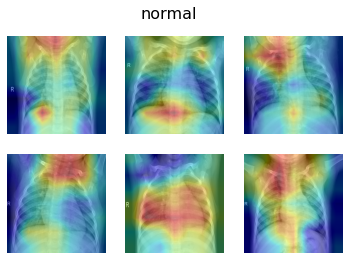

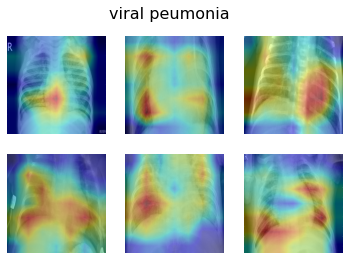

In [ ]:
import matplotlib.pyplot as plt
import os

normal = "/content/drive/MyDrive/XAI/gradcam/NORMAL"
pneumonia = "/content/drive/MyDrive/XAI/gradcam/Viral Pneumonia"

dir = [normal, pneumonia]
for directory in dir:
  print(directory)
  if directory == normal:
    category = "normal"
  if directory == pneumonia:
    category = "viral peumonia"
  plt.figure()
  plt.suptitle(category, fontsize=16)
  for i, file in enumerate(os.listdir(directory)[0:6]):
    fullpath = directory + "/" + file
    img = plt.imread(fullpath)
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

### Plotting Heatmaps of different folds next to each other

Here the different heatmaps are simply plot next to each other in one image.

First the individual gradcam-heatmap-images are created with the `AUCMEDI xai_decoder`-function.  

**Sidenote:** If I hadn't worked with cross-validation the `xai_decoder` of `AUCMEDI` would just need to be applied to the one saved model (for example the best model saved during training) and it's predictions.  

```
  decoder.xai_decoder(predict_generator, model, preds=pred, method="gradcam", layerName=None,
                alpha=0.4, out_path=xai_path)
```

Additionally to `gradcam` the methods `gradcam++`, `SaliencyMap` and `GuidedBackpropagation` are available in `AUCMEDI`.


In [ ]:
Path("/content/drive/MyDrive/XAI/gradcam/fold1/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/fold1/Viral Pneumonia").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/fold2/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/fold2/Viral Pneumonia").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/fold3/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/fold3/Viral Pneumonia").mkdir(parents=True, exist_ok=True)

for fold in range(k):
  path = '/content/drive/MyDrive/Models/fold' + str(fold+1) + '.h5'
  model.load(file_path=path)
  pred = model.predict(prediction_generator=predict_generator)
  xai_path = '/content/drive/MyDrive/XAI/gradcam/fold' + str(fold+1) 

  decoder.xai_decoder(predict_generator, model, preds=pred, method="gradcam", layerName=None,
                alpha=0.4, out_path=xai_path)

13/13 [==============================] - 8s 619ms/step


The `xai_decoder`-function automatically saves the calculated heatmeaps (overlayed over the original image) in the destinated `out_path`, if the `out_path` is given. Otherwise the images and their corresponding heatmaps are returned.

The calculated heatmap-images look like this:

/content/drive/MyDrive/XAI/gradcam/fold1
/content/drive/MyDrive/XAI/gradcam/fold1/NORMAL
/content/drive/MyDrive/XAI/gradcam/fold1/Viral Pneumonia
/content/drive/MyDrive/XAI/gradcam/fold2
/content/drive/MyDrive/XAI/gradcam/fold2/NORMAL
/content/drive/MyDrive/XAI/gradcam/fold2/Viral Pneumonia
/content/drive/MyDrive/XAI/gradcam/fold3
/content/drive/MyDrive/XAI/gradcam/fold3/NORMAL
/content/drive/MyDrive/XAI/gradcam/fold3/Viral Pneumonia


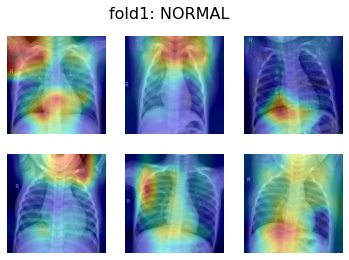

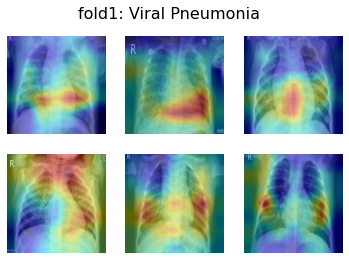

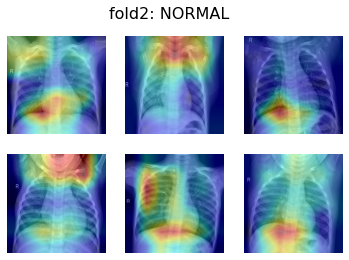

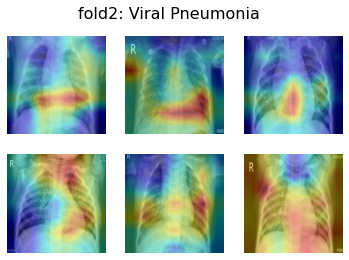

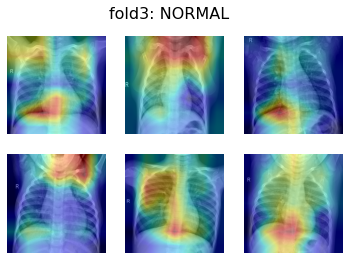

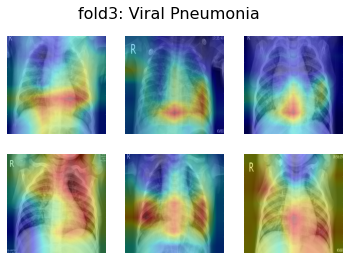

In [ ]:
import matplotlib.pyplot as plt

fold1 = "/content/drive/MyDrive/XAI/gradcam/fold1"
fold2 = "/content/drive/MyDrive/XAI/gradcam/fold2"
fold3 = "/content/drive/MyDrive/XAI/gradcam/fold3"

fold = [fold1, fold2, fold3]
for directory in fold:
  print(directory)
  if directory == fold1:
    category = "fold1"
  if directory == fold2:
    category = "fold2"
  if directory == fold3:
    category = "fold3"
  for each in sorted(os.listdir(directory)):
    plt.figure()
    plt.suptitle(category + ": " + each, fontsize=16)
    currentFolder = directory + "/" + each
    print(currentFolder)
    for i, file in enumerate(sorted(os.listdir(currentFolder)[0:6])):
      fullpath = currentFolder + "/" + file
      img = plt.imread(fullpath)
      plt.subplot(2, 3, i+1)
      plt.axis('off')
      plt.imshow(img)
plt.show()

Then I loop through the folders where the heatmap-images are saved and plot them next to each other.  
`plt.close(f)` is important because otherwise the plots stay open and consume memory.  
First for the `normal` images...

In [ ]:
import matplotlib.pyplot as plt

Path("/content/drive/MyDrive/XAI/gradcam/average/NORMAL").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/gradcam/average/Viral Pneumonia").mkdir(parents=True, exist_ok=True)

# normal
fold1 = "/content/drive/MyDrive/XAI/gradcam/fold1/NORMAL"
fold2 = "/content/drive/MyDrive/XAI/gradcam/fold2/NORMAL"
fold3 = "/content/drive/MyDrive/XAI/gradcam/fold3/NORMAL"

folds = [fold1, fold2, fold3]

images = os.listdir(fold1)

plt.figure()
for image in images:
  f, axarr = plt.subplots(1,3, figsize=(10, 4)) 
  fold1_img = fold1 + "/" + image
  fold2_img = fold2 + "/" + image
  fold3_img = fold3 + "/" + image
  img1 = plt.imread(fold1_img)
  img2 = plt.imread(fold2_img)
  img3 = plt.imread(fold3_img)
  axarr[0].imshow(img1)
  axarr[0].set_title("fold1", fontsize=12)
  axarr[0].axis('off')
  axarr[1].imshow(img2)
  axarr[1].set_title("fold2", fontsize=12)
  axarr[1].axis('off')
  axarr[2].imshow(img3)
  axarr[2].set_title("fold3", fontsize=12)
  axarr[2].axis('off')
  plt.suptitle("Comparison of the XAI-heatmaps for fold1, fold2 & fold3", fontsize=16)
  plt.savefig("/content/drive/MyDrive/XAI/gradcam/average/NORMAL/" + image)
  plt.close(f)




<Figure size 432x288 with 0 Axes>

... and then the same for the `viral pneumonia` images:

In [ ]:
# viral pneumonia
fold1 = "/content/drive/MyDrive/XAI/gradcam/fold1/Viral Pneumonia"
fold2 = "/content/drive/MyDrive/XAI/gradcam/fold2/Viral Pneumonia"
fold3 = "/content/drive/MyDrive/XAI/gradcam/fold3/Viral Pneumonia"

folds = [fold1, fold2, fold3]

images = os.listdir(fold1)

plt.figure()
for image in images:
  f, axarr = plt.subplots(1,3, figsize=(10, 4)) 
  fold1_img = fold1 + "/" + image
  fold2_img = fold2 + "/" + image
  fold3_img = fold3 + "/" + image
  img1 = plt.imread(fold1_img)
  img2 = plt.imread(fold2_img)
  img3 = plt.imread(fold3_img)
  axarr[0].imshow(img1)
  axarr[0].set_title("fold1", fontsize=12)
  axarr[0].axis('off')
  axarr[1].imshow(img2)
  axarr[1].set_title("fold2", fontsize=12)
  axarr[1].axis('off')
  axarr[2].imshow(img3)
  axarr[2].set_title("fold3", fontsize=12)
  axarr[2].axis('off')
  plt.suptitle("Comparison of the XAI-heatmaps for fold1, fold2 & fold3", fontsize=16)
  plt.savefig("/content/drive/MyDrive/XAI/gradcam/average/Viral Pneumonia/" + image)
  plt.close(f)

<Figure size 432x288 with 0 Axes>

The result is saved in a google-drive-folder and looks like this. (Each row of three pictures is saved in one image).

/content/drive/MyDrive/XAI/gradcam/average/NORMAL
/content/drive/MyDrive/XAI/gradcam/average/Viral Pneumonia


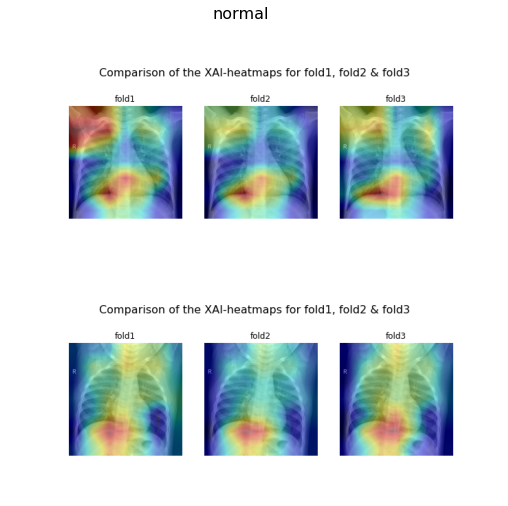

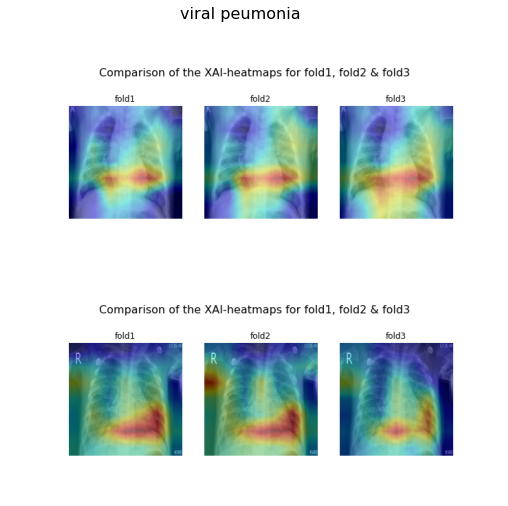

In [ ]:
import matplotlib.pyplot as plt

normal = "/content/drive/MyDrive/XAI/gradcam/average/NORMAL"
pneumonia = "/content/drive/MyDrive/XAI/gradcam/average/Viral Pneumonia"

dir = [normal, pneumonia]
for directory in dir:
  print(directory)
  if directory == normal:
    category = "normal"
  if directory == pneumonia:
    category = "viral peumonia"
  plt.figure(figsize=[15, 8])
  plt.suptitle(category, fontsize=16)
  for i, file in enumerate(os.listdir(directory)[0:2]):
    fullpath = directory + "/" + file
    img = plt.imread(fullpath)
    plt.subplot(2, 1, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Lime

Lime generates Superpixels. The Superpixels are generated by a segmentation of the image into different meaningful parts. This Superpixels are switched on and off and this way pictures are generated were some Superpixels are switched on and others of. The Lime-Algothims calculates the influence of every Superpixel on the prediction of the class. The Superpixel with the greatest influence are shown.


Installing Lime

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 28.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=6fb4f431237dc8738b016d69a4cddf7f203665976f8b98538d954a62fb282f97
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


Here I use the `LimeImageExplainer` on one random `viral pneumonia` image for the predictions of fold1. Averaging could be done similarly as for Gradcam or images for all three folds could be printed next to each other (see code for Gradcam), but a lot of compuational resources are needed for these kind of computations: In order to use the `LimeImageExplainer` on all images I would need to loop through all images.  

Since the predict-function needs an sequence of images rather then just one image I transform the image into a normalized np-array: 

```
img = Image.open(img_path).convert(mode='RGB').resize((224, 224), Image.ANTIALIAS)
img = np.asarray(img).reshape((1, 224, 224, 3)) / 255
```

Accordingly the output-format of predict is of size `(1,2)`, for example the array `[[0.00243046 0.9975695 ]]`.

The prediction for the image can therefore be gathered with `np.argmax(pred_one_image[0])`  

As input to the `LimeImageExplainer` the 1-dimension of the Image-Array needs to be deleted with `np.squeeze`.  

Finally the `LimeImageExplainer` can be build according to https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image

```
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, model.predict, top_labels=1, num_samples=1000)
temp, mask = explanation.get_image_and_mask(pred_one_image, positive_only=True, num_features=250, hide_rest=True)
```

The mask and the image are combined into one image with `mark_boundaries` of `skimage.segmentation`.




In [ ]:
from pathlib import Path
from aucmedi.data_processing import io_data
from aucmedi.neural_network import model
from aucmedi.neural_network import architectures
from lime import lime_image
import random
import numpy as np
from PIL import Image
from skimage.segmentation import mark_boundaries

Path("/content/drive/MyDrive/XAI/Lime/Viral Pneumonia").mkdir(parents=True, exist_ok=True)
Path("/content/drive/MyDrive/XAI/Lime/NORMAL").mkdir(parents=True, exist_ok=True)

rand = random.randint(201,403)
# These part is only necessary if the connection to the runtime got lost due to Out-Of-Memory Error:
# ds_loader_predict = io_data.input_interface("directory", path_imagedir="/content/Pneumonia_Classification_test_models", path_data=None, training=True, ohe=False)
img1 = ds_loader_predict[0][rand]

img_path = '/content/Pneumonia_Classification_test_models/' + img1

img = Image.open(img_path).convert(mode='RGB').resize((224, 224), Image.ANTIALIAS)
img = np.asarray(img).reshape((1, 224, 224, 3)) / 255

# These parts are only necessary if the connection to the runtime got lost due to Out-Of-Memory Error:

#architecture = architectures.Architecture_MobileNetV2(channels = 3)
#model = model.Neural_Network(n_labels=2, channels=3, input_shape=(224, 224, 3), architecture = architecture, pretrained_weights=True, 
#                             loss="categorical_crossentropy", metrics=["categorical_accuracy"], activation_output="softmax", 
#                             fcl_dropout=True, learninig_rate=0.0001, batch_queue_size=10, workers=1, multiprocessing=False, verbose=1)

model.load(file_path='/content/drive/MyDrive/Models/fold1.h5')
pred_one_image = model.predict(prediction_generator=img)
print(pred_one_image)
print(pred_one_image.shape)
pred_one_image = np.argmax(pred_one_image[0])
print(pred_one_image)

img = np.squeeze(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, model.predict, top_labels=1, num_samples=1000)
temp, mask = explanation.get_image_and_mask(pred_one_image, positive_only=True, num_features=250, hide_rest=True)

final_img = mark_boundaries(temp, mask)

plt.imsave('/content/drive/MyDrive/XAI/Lime/' + img1, final_img) 

1/1 [==============================] - 0s 5ms/step
[[3.7200074e-04 9.9962795e-01]]
(1, 2)
1


1/1 [==============================] - 0s 11ms/step



Here is an example of an explaination-image generated with the Lime-Algorithm:

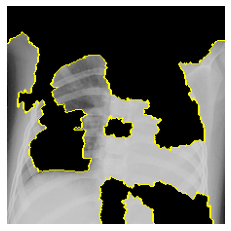

In [ ]:
import matplotlib.pyplot as plt

lime = "/content/drive/MyDrive/XAI/Lime/Viral Pneumonia"
lime_pic = os.listdir(lime)[0]
fullpath = "/content/drive/MyDrive/XAI/Lime/Viral Pneumonia" + "/" + lime_pic

plt.figure()
plt.axis('off')
img = plt.imread(fullpath)
plt.imshow(img)
plt.show()

Only the superpixel = the parts of the image that have the greatest influence on the prediction of the class (in this example `viral pneumonia`) are shown.



# Discussion

Here, X-ray images are used to differentiate “viral pneumonia” from “normal” cases. However, X-ray images can also be used to determine the source of pneumonia, bacterial versus viral (Ruuskanen et al.). The distinction is important for the choice of correct treatment. Therefore it would be interesting to test this deep-learning pipeline on such a task.  

Viral pneumonia affects mostly children younger than 5 years and adults older than 75 years (Ruuskanen et al.). However, the image-set only contains images of children. As the classifier is trained on this images-set it might not work well, when predicting on images of adults. This is a problem that commonly arises in medical contexts and points to the importance of representative training-datasets.  

The metrics of the classifier show, that it seems to perform well. Of course it would be important to compare it to established methods such as PCR.  

Furthermore it would be interesting to compare the output of different XAI-methods in a quantitative way to validate if the same features of the images are marked as relevant. In this regard the interrater-reliability between medical professionals and XAI-algorithms regarding the most informative image-features would also provide further inside.


---
Ruuskanen O, Lahti E, Jennings LC, Murdoch DR. Viral pneumonia. The Lancet. 2011;377(9773):1264–75. doi:10.1016/S0140-6736(10)61459-6


# Contact

Pia Schneider, Student Research Assistant at the chair for IT-Infrastructure for Translational Medical Research, University of Augsburg, Germany